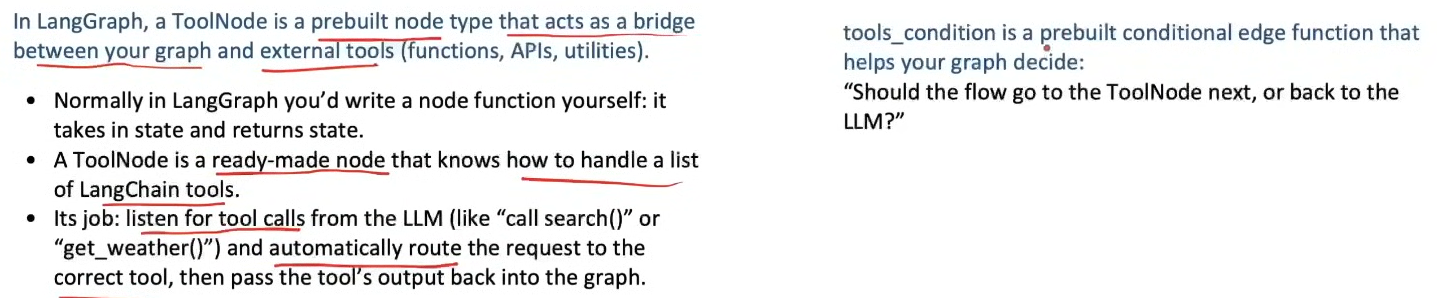

In [3]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_groq import ChatGroq
from langgraph.graph.message import add_messages
from dotenv import load_dotenv

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool

import requests
import random

In [4]:
load_dotenv()

llm = ChatGroq(model = "openai/gpt-oss-20b",
    temperature=0,
    max_tokens=None,
    reasoning_format="parsed",
    timeout=None,
    max_retries=2)

In [6]:
# Tools
search_tool = DuckDuckGoSearchRun(region="us-en")

@tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}


@tool
def get_stock_price(symbol: str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"
    r = requests.get(url)
    return r.json()

In [7]:
# Make tool list
tools = [get_stock_price, search_tool, calculator]

# Make the LLM tool-aware
llm_with_tools = llm.bind_tools(tools)

In [8]:
# state
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [9]:
# graph nodes
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

tool_node = ToolNode(tools)  # Executes tool calls

In [10]:
# graph structure
graph = StateGraph(ChatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

In [11]:
graph.add_edge(START, "chat_node")

# If the LLM asked for a tool, go to ToolNode; else finish
graph.add_conditional_edges("chat_node", tools_condition)

graph.add_edge("tools", "chat_node")   

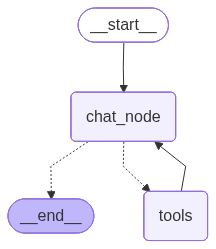

In [12]:
chatbot = graph.compile()

chatbot

In [13]:
# Regular chat
out = chatbot.invoke({"messages": [HumanMessage(content="Hello!")]})

print(out["messages"][-1].content)

Hello! How can I help you today?


In [ ]:
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
print(out["messages"][-1].content)

2 × 3 = 6.


In [16]:
out = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of apple")]})
print(out["messages"][-1].content)
out

The current price of Apple (AAPL) is **$269.00** per share (as of the latest trading day, 2025‑10‑28).


{'messages': [HumanMessage(content='What is the stock price of apple', additional_kwargs={}, response_metadata={}, id='b92366b9-0cf2-4a38-bbb5-ac601916c14b'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'User asks: "What is the stock price of apple". We need to fetch latest stock price for symbol \'AAPL\' using get_stock_price. Use function.', 'tool_calls': [{'id': 'fc_e846c7bb-25a7-4a55-a279-8a0f32bcc696', 'function': {'arguments': '{"symbol":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 248, 'total_tokens': 307, 'completion_time': 0.058057957, 'prompt_time': 0.013905751, 'queue_time': 0.047667439, 'total_time': 0.071963708}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a45989de-ffde-428d-b4ca-60155ccfca6b-0', tool_calls=[{'name': 'get_stock_price', 'args': {

In [17]:
out = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out["messages"][-1].content)

**Apple (AAPL) – Current Price**  
- Latest quoted price: **$269.00** per share (as of 2025‑10‑28)

**Cost to buy 50 shares**  
- 50 shares × $269.00/share = **$13,450.00**

So, purchasing 50 shares of Apple would cost you **$13,450**.


In [18]:
out

{'messages': [HumanMessage(content='First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?', additional_kwargs={}, response_metadata={}, id='789f5bca-cd5d-41e7-b150-cdf207a2ddcf'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'We need to call get_stock_price with symbol "AAPL". Then use calculator to multiply price by 50. Need to get price. Let\'s call get_stock_price.', 'tool_calls': [{'id': 'fc_ebf0de21-bd84-4cfa-89b3-9bbded9a50b5', 'function': {'arguments': '{"symbol":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 273, 'total_tokens': 333, 'completion_time': 0.059535141, 'prompt_time': 0.013203033, 'queue_time': 0.047075547, 'total_time': 0.072738174}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_77f8660d1d', 'service_tier': 'on_demand', 'finish_reason': 'tool_c